In [26]:
# Code based on Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com, ai-investor.net
# Code uses bulk download data from the (presumably) nice people at https://simfin.com/.

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from platform import python_version
print(python_version())

3.7.7


# 1. Get The Stock Fundamental Data
Differs slightly from part 1, as includes balance sheet this time.
(Income Statement as well as Balance Sheet)

In [27]:
# Get the stock income statement data from SimFin.com bulk download
def getXData():
    a=pd.read_csv('us-income-annual.csv', delimiter=';')
    print('Income Statement CSV is: ', a.shape)
    b=pd.read_csv('us-balance-annual.csv', delimiter=';')
    print('Balance Sheet CSV is: ', b.shape)
    c = pd.merge(a, b, on=['Ticker','SimFinId','Currency','Fiscal Year','Report Date','Publish Date'])
    c["Report Date"] = pd.to_datetime(c["Report Date"])
    c["Publish Date"] = pd.to_datetime(c["Publish Date"])
    return c

In [28]:
x = getXData()

Income Statement CSV is:  (17771, 28)
Balance Sheet CSV is:  (17771, 30)


In [29]:
x.keys()

Index(['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period_x',
       'Report Date', 'Publish Date', 'Restated Date_x', 'Shares (Basic)_x',
       'Shares (Diluted)_x', 'Revenue', 'Cost of Revenue', 'Gross Profit',
       'Operating Expenses', 'Selling, General & Administrative',
       'Research & Development', 'Depreciation & Amortization',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_y', 'Restated Date_y', 'Shares (Basic)_y',
       'Shares (Diluted)_y', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term 

# 2. Get the Stock Performance Data From Part 2
Running the getYPricesReportDateAndTargetDate() function from the previous notebook would take awhile. Luckily we saved the result, so we can just load it again.

In [30]:
# Get the daily share price data from SimFin.com bulk download
def getYRawData():
    d=pd.read_csv('us-shareprices-daily.csv', delimiter=';')
    d["Date"]=pd.to_datetime(d["Date"])
    print('Stock Price data matrix is: ',d.shape)
    return d


# Return just the price and volume near date (as have imperfect data).
# Want the volume data returned, to remove stocks with near 0 volume later.
# d is just the raw daily stock price data
# Modifier modifies the date to look between.
def getYPriceDataNearDate(ticker, date, modifier, d):
    windowDays=5
    rows = \
    d[(d["Date"].between(pd.to_datetime(date) + pd.Timedelta(days=modifier),\
       pd.to_datetime(date) + pd.Timedelta(days=windowDays+modifier))) \
      & (d["Ticker"]==ticker)]
    if rows.empty:
        return [ticker, np.float("NaN"),\
                np.datetime64('NaT'),\
                np.float("NaN")]
    else:
        return [ticker, rows.iloc[0]["Open"],\
                rows.iloc[0]["Date"],\
                rows.iloc[0]["Volume"]*rows.iloc[0]["Open"]]
        #take the first item of the list of days that fall in the window of accepted days.
        

        
# Modifier is effectively the hold period for a stock (here it is 1 year)
# x is the vector of company data
# d is the raw daily stock price data data (stock price and date for all days)
def getYPricesReportDateAndTargetDate(x, d, modifier=365):
    i=0
    # Preallocation list of list of 2 \
    # [(price at date) (price at date + modifier)]
    y = [[None]*8 for i in range(len(x))] 
    
    whichDateCol='Publish Date' # is the performance date from->to. Want this to be publish date.
    
    # Because of time lag between report date\
    # (which can't be actioned on) and publish date\
    # (data we can trade with)
    for index in range(len(x)):
        y[i]=(getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], 0, d) + \
              getYPriceDataNearDate(\
            x['Ticker'].iloc[index], x[whichDateCol].iloc[index], modifier, d))
        i=i+1
    return y

In [31]:
# We want to know the performance for each stock, each year, between 10-K report dates.
# takes VERY long time, several hours.
d = getYRawData()
y = getYPricesReportDateAndTargetDate(x, d, 365) # because of lookups in this function.
y = pd.DataFrame(y, columns=['Ticker', 'Open Price', 'Date', 'Volume', 'Ticker2', 'Open Price2', 'Date2', 'Volume2'])

Stock Price data matrix is:  (5884948, 11)


In [32]:
y.to_csv("Annual_Stock_Price_Performance_.csv")
#y = pd.read_csv("Annual_Stock_Price_Performance_.csv", index_col=0)

# 3. Filter Down the Data, Create a P/S Column
Due to imperfect data etc.

In [37]:
# Issue where no share price
bool_list = ~y["Open Price"].isnull()
y=y[bool_list]
x=x[bool_list]

# Issues where no listed number of shares
bool_list = ~x['Shares (Diluted)_x'].isnull()
y=y[bool_list]
x=x[bool_list]

# Issue where there is low/no volume
bool_list =   ~((y['Volume']<1e4) | (y['Volume2']<1e4))
y=y[bool_list]
x=x[bool_list]

# Issue where dates missing (Removes latest data too, which we can't use)
bool_list = ~y["Date2"].isnull()
y=y[bool_list]
x=x[bool_list]
               
y=y.reset_index(drop=True)
x=x.reset_index(drop=True)

In [38]:
# Create Market Cap Column
x["Market Cap"] = y["Open Price"]*x["Shares (Diluted)_x"]

In [39]:
print(x.shape)
print(y.shape)

(13866, 53)
(13866, 8)


In [40]:
def fixNansInX():
    x.loc[x["Revenue"].isnull(), "Revenue"]=0
            
def maxMinRatio(m, text, max, min):
    m.loc[x[text]>max,text]=max
    m.loc[x[text]<min,text]=min
            
def getYPerf(y):
    y_perf=pd.DataFrame()
    y_perf["Ticker"] = y["Ticker"]
    y_perf["Perf"]=(y["Open Price2"]-y["Open Price"])/y["Open Price"]
    y_perf[y_perf["Perf"].isnull()]=0 #y.fillna(0)
    return y_perf

In [41]:
fixNansInX()
x["P/S"] = x["Market Cap"] / x["Revenue"] 
maxMinRatio(x, "P/S", 1e5, 0) # Remove Infinities

y_perf = getYPerf(y)

In [76]:
y_perf

,Ticker,Perf
0,A,0.936104
1,A,0.373311
2,A,-0.036180
3,A,0.185295
4,A,0.416215
...,...,...
13861,low,0.018521
13862,low,0.096215
13863,low,0.029423
13864,low,0.246709


# 4. Altman Z Scores
To account for bankruptcy risk we use Altman scores. The lower the score, the higher the probability of default.

We need to calculate a few ratios from the stock fundamental data to compute the result.

After that we create a new column containing the Z score, after which we can exclude any company with a low score.

In [44]:
x["EBIT"] = x["Net Income"] \
    - x["Interest Expense, Net"] \
    - x["Income Tax (Expense) Benefit, Net"]

# Altman ratios 
x["(CA-CL)/TA"] = (x["Total Current Assets"]\
                   - x["Total Current Liabilities"])\
                    /x["Total Assets"]

# RE/TA
x["RE/TA"] = x["Retained Earnings"]/x["Total Assets"]

# EBIT/TA
x["EBIT/TA"] = x["EBIT"]/x["Total Assets"]

# Book Equity/TL
x["Book Equity/TL"] = x["Total Equity"]/x["Total Liabilities"]

In [45]:
# Calculate Altman Z'' scores 1995
x['Z score'] = 3.25 \
+ 6.51 * x['(CA-CL)/TA']\
+ 3.26 * x['RE/TA']\
+ 6.72 * x['EBIT/TA']\
+ 1.05 * x['Book Equity/TL']

In [46]:
x.keys()

Index(['Ticker', 'SimFinId', 'Currency', 'Fiscal Year', 'Fiscal Period_x',
       'Report Date', 'Publish Date', 'Restated Date_x', 'Shares (Basic)_x',
       'Shares (Diluted)_x', 'Revenue', 'Cost of Revenue', 'Gross Profit',
       'Operating Expenses', 'Selling, General & Administrative',
       'Research & Development', 'Depreciation & Amortization',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_y', 'Restated Date_y', 'Shares (Basic)_y',
       'Shares (Diluted)_y', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term 

# 5. Backtests

In [69]:
def getBestStocksForYear(year, x): # Fiscal Year
    return x[x['Fiscal Year']==year].nlargest(20, 'P/S').index

def getBestStocksForYearAboveZScore(year, x, z_score): # Fiscal Year
    bl=x['Z score']>= z_score
    return x[bl][x[bl]['Fiscal Year']==year].nlargest(20, 'P/S').index

In [74]:
ann_returns=[]
indx_rtn, indx_rtns=1, []

for yr in range(2008,2019):
    #indx = getBestStocksForYear(yr, x) # Pick Low P/S stocks WITHOUT bankruptcy consideration
    indx = getBestStocksForYearAboveZScore(yr, x, 3) # Pick Low P/S stocks WITH bankruptcy consideration
    #print(x.loc[indx]['Publish Date'])
    port_return = y_perf.loc[indx]['Perf'].mean()
    print('Portfolio Return was: ', round(port_return,2), 'for Fiscal Year: ',yr)
    indx_rtn = indx_rtn*(1+port_return)
    indx_rtns.append(indx_rtn) 
    ann_returns.append(port_return)
    for ii in indx:
        print(y_perf.loc[ii]['Ticker'], 'Return: ', round(y_perf.loc[ii]['Perf'],2), 'Z score: ', round(x.loc[ii]['Z score'],2))
    print('------------------------------------------------------')

Portfolio Return was:  0.31 for Fiscal Year:  2008
LH Return:  0.17 Z score:  7.47
V Return:  0.52 Z score:  6.42
CELG Return:  0.07 Z score:  7.39
FSLR Return:  -0.2 Z score:  10.07
GILD Return:  -0.1 Z score:  10.82
AMT Return:  0.37 Z score:  3.64
BLK Return:  -0.03 Z score:  5.62
VTR Return:  0.46 Z score:  4.34
AKAM Return:  0.45 Z score:  5.57
CME Return:  0.6 Z score:  6.66
AMGN Return:  0.01 Z score:  7.03
RRC Return:  0.59 Z score:  5.32
FLIR Return:  0.28 Z score:  11.97
BCR Return:  -0.08 Z score:  11.71
ADBE Return:  0.74 Z score:  12.75
CRM Return:  1.51 Z score:  5.9
KO Return:  0.25 Z score:  8.58
MCO Return:  0.19 Z score:  9.24
ATVI Return:  0.04 Z score:  8.34
COG Return:  0.4 Z score:  5.86
------------------------------------------------------
Portfolio Return was:  0.41 for Fiscal Year:  2009
LH Return:  0.28 Z score:  7.51
ODFL Return:  0.65 Z score:  6.3
V Return:  0.03 Z score:  7.98
Joe Return:  0.07 Z score:  9.76
ALXN Return:  0.78 Z score:  12.06
CLR Return:

Text(0.5, 1.0, 'Low P/S Strategy - Annual Portfolio Performance\n Z Score Cutoff of 3')

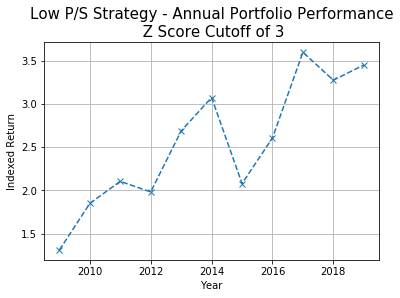

In [83]:
plt.plot(range(2009,2020),indx_rtns,'x--')
plt.grid()
plt.ylabel('Indexed Return')
plt.xlabel('Year')
plt.title('Low P/S Strategy - Annual Portfolio Performance\n Z Score Cutoff of 3',fontsize=15)

In [82]:
indx_rtns

[1.3124284966435724,
 1.850453736706596,
 2.1055789046580333,
 1.98240061052979,
 2.6884546745576996,
 3.074334901520505,
 2.0793123207923663,
 2.6068926198740097,
 3.5979580519577503,
 3.274846312531609,
 3.4503770882091445]